In [1]:
using Random
Random.seed!(87613) # Set random seed

using LinearAlgebra
using PyPlot
using ForneyLab

include("environment.jl") # Include environmental dynamics
include("helpers.jl") # Include helper functions for plotting
;

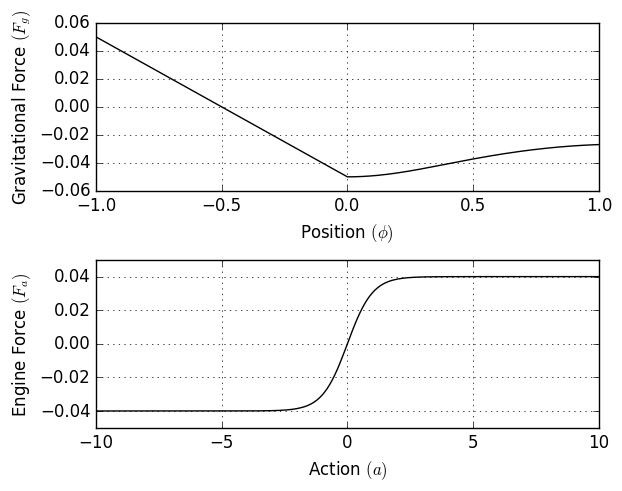

In [2]:
plotLandscape() # Visualize gravitational landscape end engine response

savefig("./figures/mc_landscape.png", dpi=300)
;

In [3]:
# Simulation for the naive policy of going full power up the right slope
N = 30 # Total simulation time

pi_naive = 100.0*ones(N) # Naive policy for right full-power only
(execute, observe) = initializeWorld() # Let there be a world

y_naive = Vector{Vector{Float64}}(undef, N)
for t = 1:N
    execute(pi_naive[t]) # Execute environmental process
    y_naive[t] = observe() # Observe external states
end
;

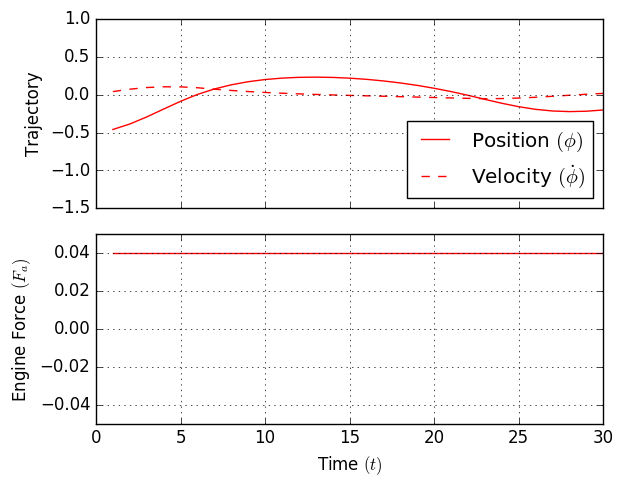

In [4]:
plotTrajectory(pi_naive, y_naive, color="red") # Plot trajectory for the naive policy
;

In [5]:
include("agent.jl") # Load agent's (accurate) internal beliefs over external dynamics

T = 20 # Lookahead

# Internal model perameters
Gamma = 1e4*diageye(2) # Transition precision
Theta = 1e-4*diageye(2) # Observation variance
;

In [6]:
# Build internal model
fg = FactorGraph()

x = Vector{Variable}(undef, T) # Observed states
s = Vector{Variable}(undef, T) # Brain states
u = Vector{Variable}(undef, T) # Control states

@RV [id=pad(:s, 0)] s_t_min ~ GaussianMeanVariance(placeholder(:m_s_t_min, dims=(2,)),
                                                   placeholder(:V_s_t_min, dims=(2,2))) # Prior brain state
s_k_min = s_t_min
for k=1:T
    @RV [id=pad(:u, k)]   u[k] ~ GaussianMeanVariance(placeholder(:m_u, var_id=:m_u_*k, index=k, dims=(1,)), 
                                                      placeholder(:V_u, var_id=:V_u_*k, index=k, dims=(1,1))) # Control prior
    @RV [id=pad(:u_h, k)] u_h_k ~ Nonlinear(u[k], h, Jh, h_inv, dims=(1,)) # Control model
    @RV [id=pad(:s_g, k)] s_g_k ~ Nonlinear(s_k_min, g, Jg, dims=(2,)) # Transition model for gravity and friction
    @RV [id=pad(:s, k)]    s[k] ~ GaussianMeanPrecision(s_g_k + u_h_k, Gamma) # State transition model including control
    @RV [id=pad(:x, k)]    x[k] ~ GaussianMeanVariance(s[k], Theta) # Observation model
    GaussianMeanVariance(x[k],
                         placeholder(:m_x, var_id=:m_x_*k, dims=(2,), index=k),
                         placeholder(:V_x, var_id=:V_x_*k, dims=(2,2), index=k)) # Goal prior
    s_k_min = s[k]
end
;

In [7]:
# Find the index of the slide message in the schedule
# If you alter the model, make sure to pass the correct message during the slide step
schedule = sumProductSchedule([s; u])
slide_msg_idx = findMessageIndex(schedule, :equ_s_01_1, 3)
;

In [8]:
# Schedule message passing algorithm
algo = sumProductAlgorithm([s; u]) # Infer internal states
eval(Meta.parse("begin $algo end")) # This evaluation loads the step!() and init() functions for inference
;

In [9]:
(execute, observe)  = initializeWorld() # Let there be a world
(infer, act, slide) = initializeAgent() # Let there be an agent

# Step through experimental protocol
a = Vector{Float64}(undef, N) # Actions
y = Vector{Vector{Float64}}(undef, N) # Observations
for t=1:N
    a[t] = act() # Evoke an action from the agent
           execute(a[t]) # The action influences hidden external states
    y[t] = observe() # Observe the current environmental outcome (update p)
           infer(a[t], y[t]) # Infer beliefs from current model state (update q)
           slide(slide_msg_idx) # Prepare for next iteration
end
;

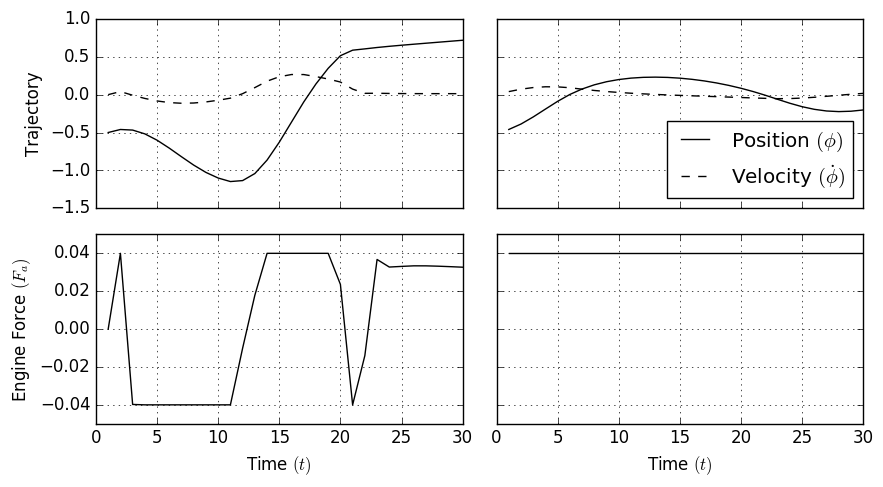

In [10]:
# Plot active inference results in left column and naive policy results in right column
plotTrajectories(a, y, pi_naive, y_naive)

savefig("./figures/mc_trajectory.png", dpi=300)
;